**Библиотеки**

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

**Устройство, на котором будем считать (если есть CUDA-совместимая видеокарта, считаем на ней, а не на CPU)**

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

**Датасет**

In [3]:
# Преобразование для обучающей выборки. transforms.AutoAugmentPolicy.CIFAR10 - готовый набор трансформаций для CIFAR10
# Можно набрать и руками из отдельных преобразований.
train_transform = transforms.Compose([
    #transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Преобразование для тестовой выборки. Преобразуем в тензор и нормализуем, искажения вносить не будем.
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Размер пакета.
batch_size = 64

# Оболочка для итерации по обучающей выборке
trainset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True, transform = train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

# Оболочка для итерации по тестовой выборке
testset = torchvision.datasets.CIFAR10(root = "./data", train = False, download = True, transform = test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = 2)

# Классы CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12556239.89it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Посмотрим содержимое датасета**

Обучающая выборка

In [4]:
n = [0 for i in range(10)]
# Плохое решение, применяем аугментацию ко всем изображениям датасета, но не используем их
for _, label in trainset:
    n[label] += 1
for i in range(10):
    print("{:s}: {:d}".format(classes[i], n[i]))

plane: 5000
car: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


Тестовая выборка

In [5]:
n = [0 for i in range(10)]
# Плохое решение, применяем аугментацию ко всем изображениям датасета, но не используем их
for _, label in testset:
    n[label] += 1
for i in range(10):
    print("{:s}: {:d}".format(classes[i], n[i]))

plane: 1000
car: 1000
bird: 1000
cat: 1000
deer: 1000
dog: 1000
frog: 1000
horse: 1000
ship: 1000
truck: 1000


Классы в датасете сбалансированы идеально. При обучении стохастическими методами необходимо перемешать данные, чтобы обеспечить равномерное обучение по всем классам. Это делается установкой параметра `shuffle=True` даталоадера

Функция для вывода изображения

In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Визуализируем содержимое выборок. Начнём с обучающей

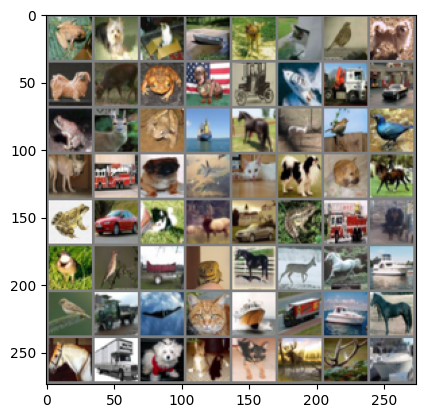

frog  dog   cat   ship  deer  cat   bird  dog   dog   deer  frog  dog   car   ship  truck car   frog  deer  frog  ship  horse deer  bird  bird  dog   truck dog   plane cat   dog   dog   horse frog  car   dog   deer  car   frog  truck dog   bird  bird  truck frog  horse deer  horse ship  bird  truck plane cat   ship  truck ship  horse horse truck dog   cat   dog   deer  deer  ship 


In [7]:
# Получим пакет из обучающей выборки и посмотрим на него
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Выводим изображения
imshow(torchvision.utils.make_grid(images))

# ...и метки
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Теперь посмотрим тестовую

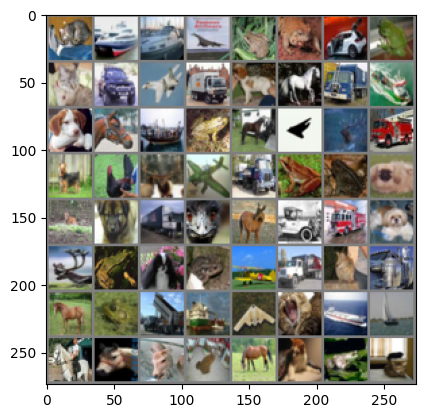

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat  


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame({
            'metric': pd.Series([], dtype = 'str'),
            'alg': pd.Series([], dtype = 'str'),
            'value': pd.Series([], dtype = 'float')
        })

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric'] == metric) & (self.df['alg'] == alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric' : metric,
                 'alg' : alg,
                 'value' : value}]
        self.df = self.df.append(temp, ignore_index = True)

    def get_data_for_metric(self, metric, ascending = True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric'] == metric]
        temp_data_2 = temp_data.sort_values(by = 'value', ascending = ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending = True, figsize = (5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize = figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos,
                         array_metric,
                         align = 'center',
                         height = 0.5, 
                         tick_label = array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a - 0.05, str(round(b, 3)), color = 'white')
        plt.show()

In [10]:
logger = MetricLogger()

**Обучаем модели**

**Блок множественных линейных регрессий (1-слойная полносвязная сеть)**

In [11]:
class FullyConnected1(nn.Module):

    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(3 * 32 * 32, 10)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [12]:
net = FullyConnected1().train().to(device)
optimizer = optim.SGD(net.parameters(), lr = 2e-4, momentum = 0.9) # Брать lr больше 0.001 здесь нельзя: обучение останавливается

[1,   200] loss: 2.061, precision: 26.219
[1,   400] loss: 1.943, precision: 32.742
[1,   600] loss: 1.894, precision: 35.477
[2,   200] loss: 1.834, precision: 36.953
[2,   400] loss: 1.837, precision: 37.633
[2,   600] loss: 1.806, precision: 38.625
[3,   200] loss: 1.790, precision: 38.836
[3,   400] loss: 1.799, precision: 39.047
[3,   600] loss: 1.789, precision: 39.875
[4,   200] loss: 1.773, precision: 40.039
[4,   400] loss: 1.783, precision: 39.594
[4,   600] loss: 1.775, precision: 40.172
[5,   200] loss: 1.757, precision: 39.922
[5,   400] loss: 1.765, precision: 40.352
[5,   600] loss: 1.756, precision: 40.438
[6,   200] loss: 1.749, precision: 40.820
[6,   400] loss: 1.743, precision: 41.219
[6,   600] loss: 1.758, precision: 40.562
[7,   200] loss: 1.743, precision: 41.297
[7,   400] loss: 1.738, precision: 41.664
[7,   600] loss: 1.732, precision: 41.188
[8,   200] loss: 1.741, precision: 41.203
[8,   400] loss: 1.724, precision: 41.719
[8,   600] loss: 1.725, precision:

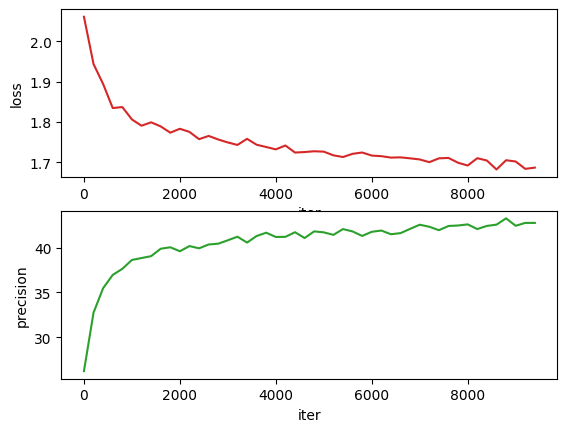

In [13]:
iters = []
losses = []
precisions = []

it = 0

for epoch in range(16):

    running_loss = 0.0
    running_precision = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = F.cross_entropy(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device)).sum().item()
        running_precision += 100 * correct / labels.size(0)
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}, precision: {running_precision / 200:.3f}')
            iters.append(it)
            losses.append(running_loss / 200)
            precisions.append(running_precision / 200)
            running_loss = 0.0
            running_precision = 0.0
            it += 200

fig, axs = plt.subplots(2)
axs[0].plot(iters, losses, 'tab:red')
axs[0].set(xlabel = 'iter', ylabel = 'loss')
axs[1].plot(iters, precisions, 'tab:green')
axs[1].set(xlabel = 'iter', ylabel = 'precision') 

for ax in axs:
    ax.plot()

In [14]:
torch.save(net.state_dict(), "fc1.pth")

In [15]:
net.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        loss += F.cross_entropy(outputs, labels.to(device), reduction = "sum").cpu().item()

logger.add('precision', "LinearRegression1", 100 * correct / total)
logger.add('cross_entropy', "LinearRegression1", loss / total)

<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)
<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)


**Классическая полносвязная сеть**

In [16]:
class FullyConnected2(nn.Module):

    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.Sigmoid(),
            nn.Linear(512, 256),
            nn.Sigmoid(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
net = FullyConnected2().train().to(device)
optimizer = optim.SGD(net.parameters(), lr = 1e-2, momentum = 0.9)

[1,   200] loss: 2.285, precision: 13.188
[1,   400] loss: 2.108, precision: 20.781
[1,   600] loss: 2.003, precision: 25.648
[2,   200] loss: 1.913, precision: 30.641
[2,   400] loss: 1.889, precision: 31.617
[2,   600] loss: 1.860, precision: 33.109
[3,   200] loss: 1.805, precision: 35.742
[3,   400] loss: 1.794, precision: 35.547
[3,   600] loss: 1.790, precision: 36.617
[4,   200] loss: 1.757, precision: 37.258
[4,   400] loss: 1.742, precision: 37.570
[4,   600] loss: 1.731, precision: 38.922
[5,   200] loss: 1.701, precision: 39.484
[5,   400] loss: 1.691, precision: 39.805
[5,   600] loss: 1.697, precision: 39.859
[6,   200] loss: 1.660, precision: 40.703
[6,   400] loss: 1.643, precision: 42.359
[6,   600] loss: 1.655, precision: 42.344
[7,   200] loss: 1.632, precision: 42.234
[7,   400] loss: 1.605, precision: 43.414
[7,   600] loss: 1.605, precision: 42.820
[8,   200] loss: 1.577, precision: 44.008
[8,   400] loss: 1.576, precision: 44.258
[8,   600] loss: 1.581, precision:

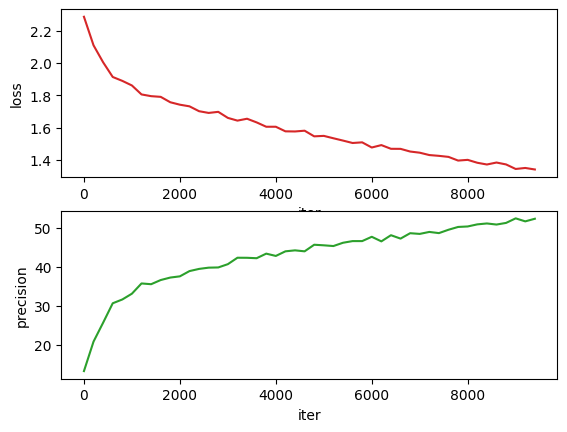

In [18]:
iters = []
losses = []
precisions = []

it = 0

for epoch in range(16):

    running_loss = 0.0
    running_precision = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = F.cross_entropy(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device)).sum().item()
        running_precision += 100 * correct / labels.size(0)
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}, precision: {running_precision / 200:.3f}')
            iters.append(it)
            losses.append(running_loss / 200)
            precisions.append(running_precision / 200)
            running_loss = 0.0
            running_precision = 0.0
            it += 200

fig, axs = plt.subplots(2)
axs[0].plot(iters, losses, 'tab:red')
axs[0].set(xlabel = 'iter', ylabel = 'loss')
axs[1].plot(iters, precisions, 'tab:green')
axs[1].set(xlabel = 'iter', ylabel = 'precision') 

for ax in axs:
    ax.plot()

In [19]:
torch.save(net.state_dict(), "fc2.pth")

In [20]:
net.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        loss += F.cross_entropy(outputs, labels.to(device), reduction = "sum").cpu().item()

logger.add('precision', "FullyConnected", 100 * correct / total)
logger.add('cross_entropy', "FullyConnected", loss / total)

<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)
<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)


**Свёрточная сеть (LeNet-5)**

In [21]:
class Conv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size = 5, padding = 2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(6, 16, kernel_size = 5, padding = 2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 8 * 8, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
net = Conv1().train().to(device)
optimizer = optim.SGD(net.parameters(), lr = 1e-2, momentum = 0.9)

[1,   200] loss: 2.043, precision: 25.664
[1,   400] loss: 1.797, precision: 36.828
[1,   600] loss: 1.696, precision: 40.141
[2,   200] loss: 1.508, precision: 46.312
[2,   400] loss: 1.467, precision: 47.445
[2,   600] loss: 1.418, precision: 48.836
[3,   200] loss: 1.323, precision: 52.484
[3,   400] loss: 1.323, precision: 52.516
[3,   600] loss: 1.293, precision: 53.672
[4,   200] loss: 1.219, precision: 56.500
[4,   400] loss: 1.223, precision: 55.914
[4,   600] loss: 1.208, precision: 56.898
[5,   200] loss: 1.149, precision: 59.234
[5,   400] loss: 1.153, precision: 59.109
[5,   600] loss: 1.133, precision: 59.539
[6,   200] loss: 1.086, precision: 61.188
[6,   400] loss: 1.108, precision: 60.891
[6,   600] loss: 1.080, precision: 61.203
[7,   200] loss: 1.031, precision: 63.695
[7,   400] loss: 1.025, precision: 63.867
[7,   600] loss: 1.037, precision: 63.023
[8,   200] loss: 0.983, precision: 65.195
[8,   400] loss: 0.971, precision: 65.078
[8,   600] loss: 0.993, precision:

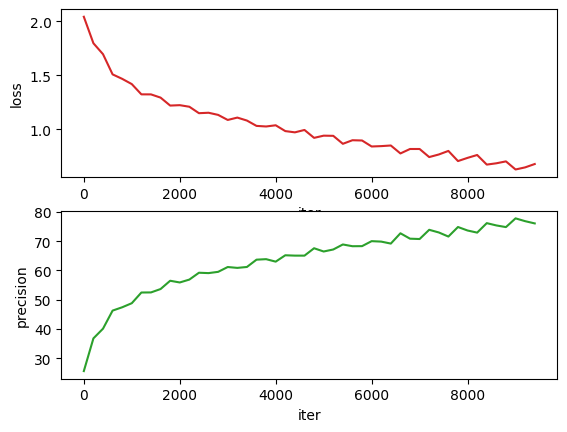

In [23]:
iters = []
losses = []
precisions = []

it = 0

for epoch in range(16):

    running_loss = 0.0
    running_precision = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = F.cross_entropy(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device)).sum().item()
        running_precision += 100 * correct / labels.size(0)
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}, precision: {running_precision / 200:.3f}')
            iters.append(it)
            losses.append(running_loss / 200)
            precisions.append(running_precision / 200)
            running_loss = 0.0
            running_precision = 0.0
            it += 200

fig, axs = plt.subplots(2)
axs[0].plot(iters, losses, 'tab:red')
axs[0].set(xlabel = 'iter', ylabel = 'loss')
axs[1].plot(iters, precisions, 'tab:green')
axs[1].set(xlabel = 'iter', ylabel = 'precision') 

for ax in axs:
    ax.plot()

In [24]:
torch.save(net.state_dict(), "conv1.pth")

In [25]:
net.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        loss += F.cross_entropy(outputs, labels.to(device), reduction = "sum").cpu().item()

logger.add('precision', "LeNet-5", 100 * correct / total)
logger.add('cross_entropy', "LeNet-5", loss / total)

<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)
<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)


Свёрточная сеть (VGG-подобная)

In [26]:
class Conv2(nn.Module):

    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(16, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [27]:
net = Conv2().train().to(device)
optimizer = optim.SGD(net.parameters(), lr = 1e-2, momentum = 0.9)

[1,   200] loss: 2.303, precision: 9.914
[1,   400] loss: 2.287, precision: 12.914
[1,   600] loss: 2.092, precision: 21.102
[2,   200] loss: 1.771, precision: 32.609
[2,   400] loss: 1.666, precision: 36.477
[2,   600] loss: 1.595, precision: 40.445
[3,   200] loss: 1.443, precision: 46.633
[3,   400] loss: 1.379, precision: 49.625
[3,   600] loss: 1.346, precision: 50.969
[4,   200] loss: 1.231, precision: 55.289
[4,   400] loss: 1.224, precision: 56.070
[4,   600] loss: 1.161, precision: 58.156
[5,   200] loss: 1.087, precision: 61.812
[5,   400] loss: 1.060, precision: 62.602
[5,   600] loss: 1.037, precision: 63.180
[6,   200] loss: 0.969, precision: 65.688
[6,   400] loss: 0.959, precision: 66.477
[6,   600] loss: 0.929, precision: 67.602
[7,   200] loss: 0.861, precision: 70.320
[7,   400] loss: 0.871, precision: 69.969
[7,   600] loss: 0.885, precision: 69.234
[8,   200] loss: 0.793, precision: 72.430
[8,   400] loss: 0.803, precision: 72.320
[8,   600] loss: 0.798, precision: 

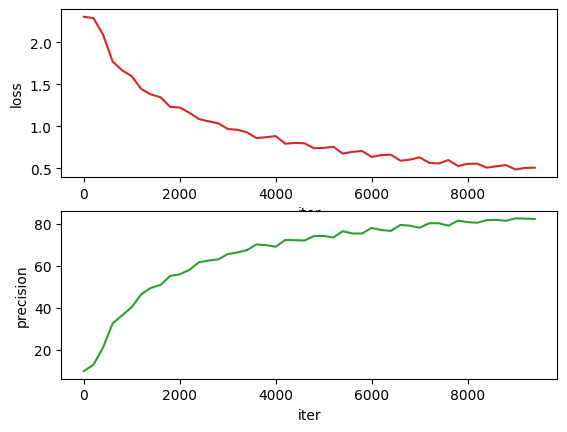

In [28]:
iters = []
losses = []
precisions = []

it = 0

for epoch in range(16):

    running_loss = 0.0
    running_precision = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = F.cross_entropy(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device)).sum().item()
        running_precision += 100 * correct / labels.size(0)
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}, precision: {running_precision / 200:.3f}')
            iters.append(it)
            losses.append(running_loss / 200)
            precisions.append(running_precision / 200)
            running_loss = 0.0
            running_precision = 0.0
            it += 200

fig, axs = plt.subplots(2)
axs[0].plot(iters, losses, 'tab:red')
axs[0].set(xlabel = 'iter', ylabel = 'loss')
axs[1].plot(iters, precisions, 'tab:green')
axs[1].set(xlabel = 'iter', ylabel = 'precision') 

for ax in axs:
    ax.plot()

In [29]:
torch.save(net.state_dict(), "conv2.pth")

In [30]:
net.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        loss += F.cross_entropy(outputs, labels.to(device), reduction = "sum").cpu().item()

logger.add('precision', "VGG7", 100 * correct / total)
logger.add('cross_entropy', "VGG7", loss / total)

<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)
<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)


**Остаточная сеть (ResNet-подобная)**

In [31]:
class ResBlock(nn.Module):

    def __init__(self, in_planes, out_planes, stride = 1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size = 3, padding = 1, stride = stride),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(),
            nn.Conv2d(out_planes, out_planes, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_planes)
        )
        self.bypass = nn.Identity() if ((in_planes == out_planes) and (stride == 1)) else nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size = 1, stride = stride),
            nn.BatchNorm2d(out_planes)
        )

    def forward(self, x):
        return F.relu(self.features(x) + self.bypass(x))

class ResNet1(nn.Module):

    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3, padding = 1, stride = 2),
            nn.ReLU(),
            ResBlock(16, 16),
            ResBlock(16, 32, stride = 2),
            ResBlock(32, 32),
            ResBlock(32, 64, stride = 2),
            ResBlock(64, 64),
            ResBlock(64, 64),
            ResBlock(64, 64)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(64, 10, kernel_size = 1),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [32]:
net = ResNet1().train().to(device)
optimizer = optim.SGD(net.parameters(), lr = 1e-2, momentum = 0.9)

[1,   200] loss: 1.819, precision: 31.672
[1,   400] loss: 1.529, precision: 44.172
[1,   600] loss: 1.421, precision: 48.344
[2,   200] loss: 1.217, precision: 56.719
[2,   400] loss: 1.147, precision: 58.680
[2,   600] loss: 1.111, precision: 60.641
[3,   200] loss: 0.965, precision: 65.641
[3,   400] loss: 0.948, precision: 66.469
[3,   600] loss: 0.950, precision: 66.062
[4,   200] loss: 0.822, precision: 70.938
[4,   400] loss: 0.823, precision: 71.359
[4,   600] loss: 0.815, precision: 70.906
[5,   200] loss: 0.703, precision: 74.484
[5,   400] loss: 0.714, precision: 74.945
[5,   600] loss: 0.737, precision: 73.945
[6,   200] loss: 0.608, precision: 78.250
[6,   400] loss: 0.641, precision: 77.344
[6,   600] loss: 0.636, precision: 77.516
[7,   200] loss: 0.525, precision: 81.000
[7,   400] loss: 0.570, precision: 80.078
[7,   600] loss: 0.577, precision: 79.320
[8,   200] loss: 0.469, precision: 83.516
[8,   400] loss: 0.492, precision: 82.695
[8,   600] loss: 0.519, precision:

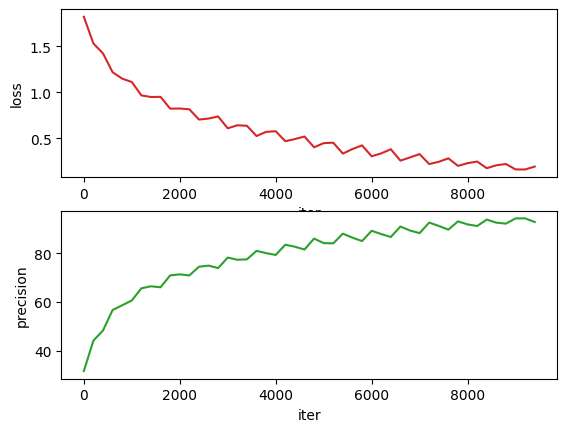

In [33]:
iters = []
losses = []
precisions = []

it = 0

for epoch in range(16):

    running_loss = 0.0
    running_precision = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = F.cross_entropy(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device)).sum().item()
        running_precision += 100 * correct / labels.size(0)
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}, precision: {running_precision / 200:.3f}')
            iters.append(it)
            losses.append(running_loss / 200)
            precisions.append(running_precision / 200)
            running_loss = 0.0
            running_precision = 0.0
            it += 200

fig, axs = plt.subplots(2)
axs[0].plot(iters, losses, 'tab:red')
axs[0].set(xlabel = 'iter', ylabel = 'loss')
axs[1].plot(iters, precisions, 'tab:green')
axs[1].set(xlabel = 'iter', ylabel = 'precision') 

for ax in axs:
    ax.plot()

In [34]:
torch.save(net.state_dict(), "resnet1.pth")

In [35]:
net.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        loss += F.cross_entropy(outputs, labels.to(device), reduction = "sum").cpu().item()

logger.add('precision', "ResNet-18", 100 * correct / total)
logger.add('cross_entropy', "ResNet-18", loss / total)

<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)
<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)


**Остаточная (WideResNet-подобная)**

In [36]:
class WideResBlock(nn.Module):

    def __init__(self, in_planes, out_planes, k = 8, stride = 1):
        super().__init__()
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.ReLU(),
            nn.Conv2d(in_planes, out_planes // 4 * k, kernel_size = 1),
            nn.BatchNorm2d(out_planes // 4 * k),
            nn.ReLU(),
            nn.Conv2d(out_planes // 4 * k, out_planes // 4 * k, kernel_size = 3, padding = 1, stride = stride),
            nn.BatchNorm2d(out_planes // 4 * k),
            nn.ReLU(),
            nn.Conv2d(out_planes // 4 * k, out_planes, kernel_size = 1)
        )
        self.bypass = nn.Identity() if ((in_planes == out_planes) and (stride == 1)) else nn.Sequential(
            nn.BatchNorm2d(in_planes),
            nn.Conv2d(in_planes, out_planes, kernel_size = 1, stride = stride)
        )

    def forward(self, x):
        return self.features(x) + self.bypass(x)

class ResNet2(nn.Module):

    def __init__(self, k = 2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16 * k, kernel_size = 3, padding = 1, stride = 2),
            nn.ReLU(),
            WideResBlock(16 * k, 16 * k),
            WideResBlock(16 * k, 16 * k),
            WideResBlock(16 * k, 32 * k, stride = 2),
            WideResBlock(32 * k, 32 * k),
            WideResBlock(32 * k, 32 * k),
            WideResBlock(32 * k, 32 * k),
            WideResBlock(32 * k, 64 * k, stride = 2),
            WideResBlock(64 * k, 64 * k),
            WideResBlock(64 * k, 64 * k),
            WideResBlock(64 * k, 64 * k),
            WideResBlock(64 * k, 64 * k),
            WideResBlock(64 * k, 64 * k)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(64 * k, 10, kernel_size = 1),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [37]:
net = ResNet2().train().to(device)
optimizer = optim.SGD(net.parameters(), lr = 1e-2, momentum = 0.9)

[1,   200] loss: 1.714, precision: 36.258
[1,   400] loss: 1.371, precision: 49.617
[1,   600] loss: 1.255, precision: 54.828
[2,   200] loss: 1.029, precision: 63.281
[2,   400] loss: 0.965, precision: 65.641
[2,   600] loss: 0.923, precision: 67.203
[3,   200] loss: 0.743, precision: 73.430
[3,   400] loss: 0.756, precision: 73.398
[3,   600] loss: 0.716, precision: 74.555
[4,   200] loss: 0.573, precision: 79.578
[4,   400] loss: 0.601, precision: 78.781
[4,   600] loss: 0.602, precision: 78.844
[5,   200] loss: 0.452, precision: 84.188
[5,   400] loss: 0.494, precision: 82.805
[5,   600] loss: 0.490, precision: 82.719
[6,   200] loss: 0.354, precision: 87.648
[6,   400] loss: 0.387, precision: 86.531
[6,   600] loss: 0.407, precision: 85.711
[7,   200] loss: 0.271, precision: 90.281
[7,   400] loss: 0.311, precision: 88.922
[7,   600] loss: 0.320, precision: 88.672
[8,   200] loss: 0.224, precision: 91.875
[8,   400] loss: 0.235, precision: 91.508
[8,   600] loss: 0.271, precision:

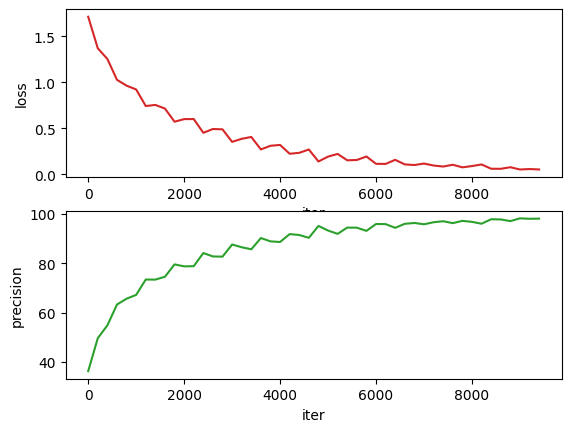

In [38]:
iters = []
losses = []
precisions = []

it = 0

for epoch in range(16):

    running_loss = 0.0
    running_precision = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = F.cross_entropy(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device)).sum().item()
        running_precision += 100 * correct / labels.size(0)
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}, precision: {running_precision / 200:.3f}')
            iters.append(it)
            losses.append(running_loss / 200)
            precisions.append(running_precision / 200)
            running_loss = 0.0
            running_precision = 0.0
            it += 200

fig, axs = plt.subplots(2)
axs[0].plot(iters, losses, 'tab:red')
axs[0].set(xlabel = 'iter', ylabel = 'loss')
axs[1].plot(iters, precisions, 'tab:green')
axs[1].set(xlabel = 'iter', ylabel = 'precision') 

for ax in axs:
    ax.plot()

In [39]:
torch.save(net.state_dict(), "resnet2.pth")

In [40]:
net.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        loss += F.cross_entropy(outputs, labels.to(device), reduction = "sum").cpu().item()

logger.add('precision', "WideResNet-40", 100 * correct / total)
logger.add('cross_entropy', "WideResNet-40", loss / total)

<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)
<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)


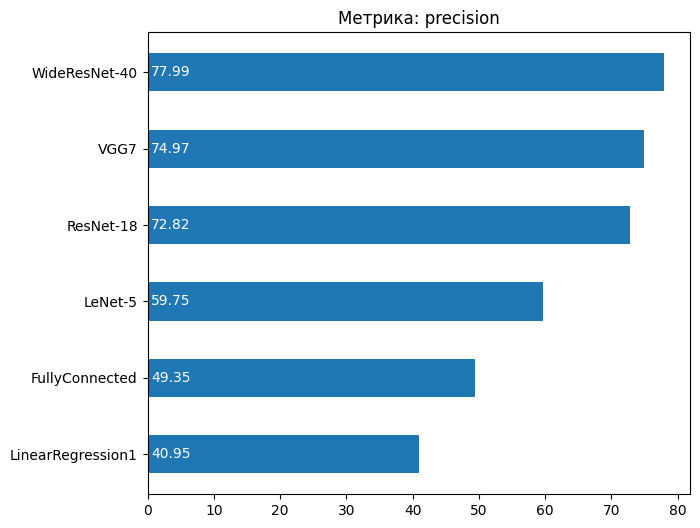

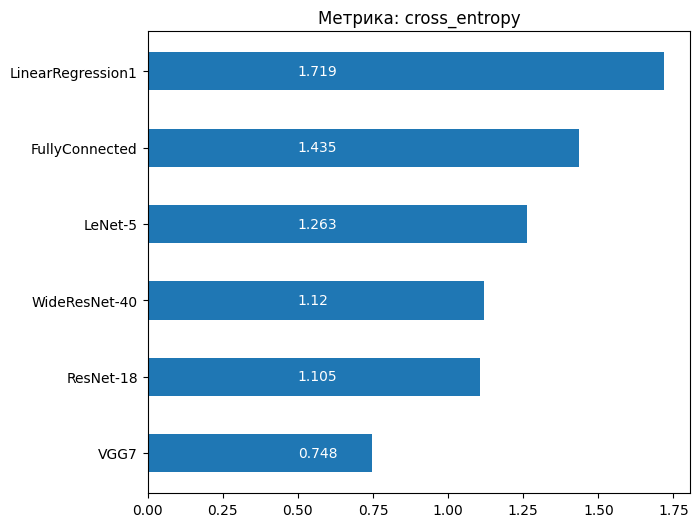

In [41]:
# Построим графики метрик качества модели
for metric in ['precision', 'cross_entropy']:
    logger.plot('Метрика: ' + metric, metric, figsize = (7, 6))

**Здесь мог бы быть подбор гиперпараметров (как минимум для оптимизатора), но зачем, если у нас есть Adam**

In [42]:
net = ResNet2().train().to(device)
optimizer = optim.Adam(net.parameters(), lr = 1e-3)

[1,   200] loss: 1.677, precision: 39.102
[1,   400] loss: 1.346, precision: 51.156
[1,   600] loss: 1.172, precision: 58.203
[2,   200] loss: 0.956, precision: 65.883
[2,   400] loss: 0.910, precision: 67.852
[2,   600] loss: 0.872, precision: 68.859
[3,   200] loss: 0.734, precision: 74.227
[3,   400] loss: 0.734, precision: 74.297
[3,   600] loss: 0.707, precision: 75.000
[4,   200] loss: 0.584, precision: 79.648
[4,   400] loss: 0.593, precision: 79.156
[4,   600] loss: 0.581, precision: 79.445
[5,   200] loss: 0.474, precision: 83.414
[5,   400] loss: 0.489, precision: 82.711
[5,   600] loss: 0.499, precision: 82.672
[6,   200] loss: 0.390, precision: 86.266
[6,   400] loss: 0.412, precision: 85.430
[6,   600] loss: 0.409, precision: 85.859
[7,   200] loss: 0.305, precision: 89.609
[7,   400] loss: 0.341, precision: 87.875
[7,   600] loss: 0.339, precision: 87.914
[8,   200] loss: 0.242, precision: 91.812
[8,   400] loss: 0.268, precision: 90.609
[8,   600] loss: 0.286, precision:

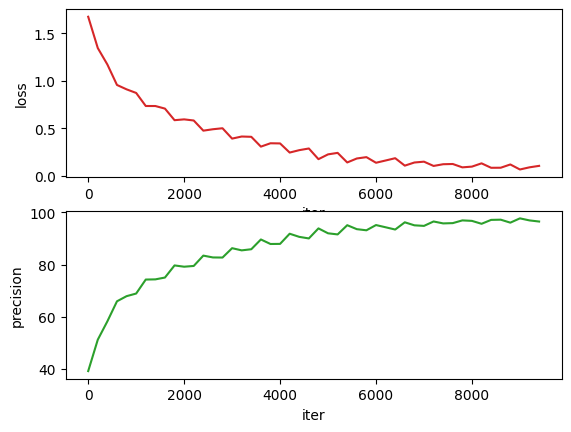

In [43]:
iters = []
losses = []
precisions = []

it = 0

for epoch in range(16):

    running_loss = 0.0
    running_precision = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = F.cross_entropy(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels.to(device)).sum().item()
        running_precision += 100 * correct / labels.size(0)
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}, precision: {running_precision / 200:.3f}')
            iters.append(it)
            losses.append(running_loss / 200)
            precisions.append(running_precision / 200)
            running_loss = 0.0
            running_precision = 0.0
            it += 200

fig, axs = plt.subplots(2)
axs[0].plot(iters, losses, 'tab:red')
axs[0].set(xlabel = 'iter', ylabel = 'loss')
axs[1].plot(iters, precisions, 'tab:green')
axs[1].set(xlabel = 'iter', ylabel = 'precision') 

for ax in axs:
    ax.plot()

In [44]:
torch.save(net.state_dict(), "best.pth")

In [45]:
net.eval()
correct = 0
total = 0
loss = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        loss += F.cross_entropy(outputs, labels.to(device), reduction = "sum").cpu().item()

logger.add('precision', "WideResNet-40-Adam", 100 * correct / total)
logger.add('cross_entropy', "WideResNet-40-Adam", loss / total)

<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)
<ipython-input-9-18dd1d6e84cc>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(temp, ignore_index = True)


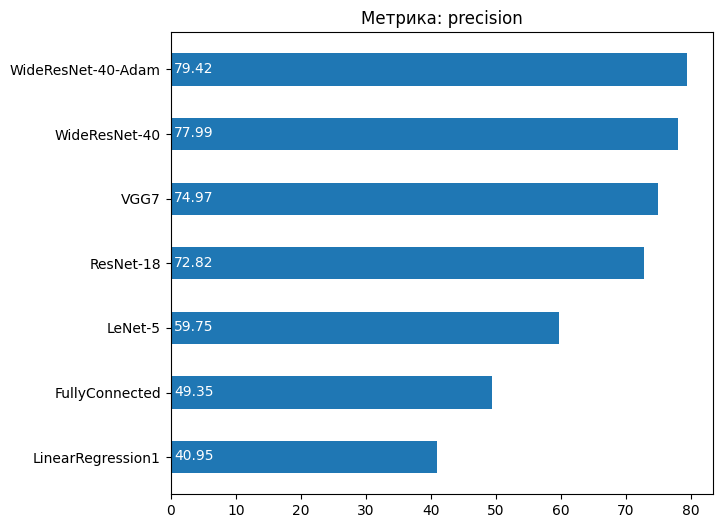

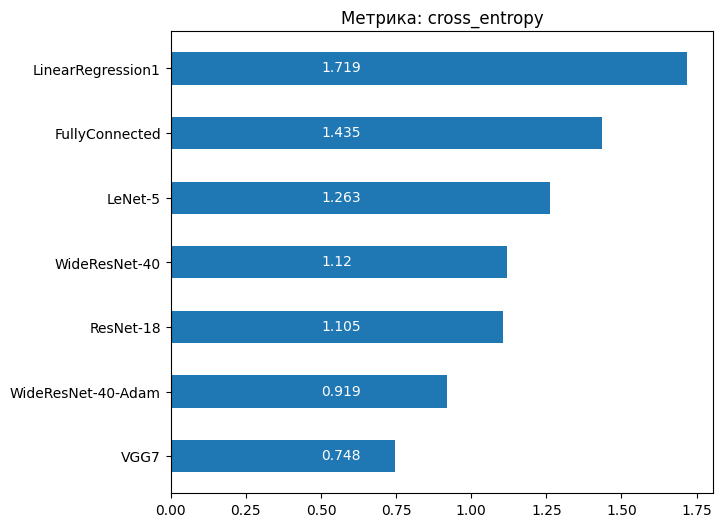

In [46]:
# Построим графики метрик качества модели
for metric in ['precision', 'cross_entropy']:
    logger.plot('Метрика: ' + metric, metric, figsize = (7, 6))